### Tests
Use of the agglomerative clustering with HR diagram.

We test here individuals clusters

In [16]:
import sys, os
sys.path.append('../../src')

from numba import jit

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.distance import pdist

import pandas as pd
import pickle

from math import ceil
import math
import gaia_utils as gu
import wavelet as wav
from sklearn import cluster
from sklearn import metrics
from sklearn.neighbors import kneighbors_graph
#from astroML.correlation import two_point
#from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 9, 6
###################################

clustername = "NGC 1901"
#clustername = "NGC 2516"
voname = 'NGC 752-1.0deg.vot'
voname = "test.vot"

RADIUS   = 1.5
kCluster = 8
votable_disk = False
distclust = 1204.
WEIGHT = [6.5, 6.5, 10.7, 4.1, 4.1, 2.1, 2.1, 2.1]
WEIGHT = [6.76, 6.76, 12.45, 4.1, 4.1, 2.77, 2.77, 2.77]
WEIGHTCART = [6.5, 4.0, 2.5]

## dscan
eps = 2.0
min_samples = 20

## Ward
neighbors = 30

In [17]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False, cartesian = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if cartesian:
        xx = df[np.where(labels == ilab),1]
        yy = df[np.where(labels == ilab),2]
    else:
        xx = df[np.where(labels == ilab),0]
        yy = df[np.where(labels == ilab),1] 
        
    if color:
        axarr[0,0].scatter(xx, yy,  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(xx,yy,  s = 0.5, c = "k")

        
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,8)
    
    plt.show()
    
    
def plot_density(df, labels, ilab, cmap = "gist_stern", NXY = 256):
    "compute the density and plot the images"
    
    fig = plt.figure(figsize=(10, 14))
    ax = fig.add_subplot(221, title='lb')
    xmin = min(df[:,0])
    xmax = max(df[:,0])
    ymin = min(df[:,1])
    ymax = max(df[:,1])
    xe = np.linspace(xmin,xmax,NXY)
    ye = np.linspace(ymin,ymax,NXY)
    
    H, xedges, yedges  = np.histogram2d(df[np.where(labels == ilab),0][0],df[np.where(labels == ilab),1][0], bins = (xe,ye))
    H = H.T
    
    plt.imshow(H, interpolation='bicubic', origin='low',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    
    wt = wav.wt()
    imw = wt.atrous(H, 6)
    imrestored = wt.restore(imw,1,6)
    
    ax = fig.add_subplot(222, title='lb-wav')
    plt.imshow(imrestored, interpolation='bicubic', norm = colors.LogNorm(vmin=0.01, vmax= 10.), origin='low',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        
    plt.show()

In [18]:
## print the physical properties of the cluster for a given label

def properties_cluster(df, labels, ilab):
    
    posx = np.median(df[np.where(labels == ilab),0])
    posy = np.median(df[np.where(labels == ilab),1])
    posz = np.median(df[np.where(labels == ilab),2])
    velra = np.median(df[np.where(labels == ilab),3])
    veldec = np.median(df[np.where(labels == ilab),4])
    stdx = np.std(df[np.where(labels == ilab),0])
    stdy = np.std(df[np.where(labels == ilab),1])
    stdz = np.std(df[np.where(labels == ilab),2])
    stdist = np.std(df[np.where(labels == ilab),2]) 
    stdvelra = np.std(df[np.where(labels == ilab),3]) 
    stdveldec = np.std(df[np.where(labels == ilab),4]) 
    
    print("## Physical properties of the label %d"%(ilab))
    print("## Pos. mean (X, Y, Z): %4.2f , %4.2f , %4.2f"%(posx, posy, posz))
    print("## Disp. (X, Y, Z): %4.2f , %4.2f , %4.2f"%(stdx, stdy, stdz))
    print("##")
    print("## Vel. mean (RA,Dec): %4.2f , %4.2f"%(velra, veldec))
    print("## Vel. disp. (RA,Dec): %4.2f , %4.2f"%(stdvelra, stdveldec))
    print("##")
    print("## Ellipticities:")
    print("## Spatial (Y/X) (Z/X) (Z/Y) : (%4.2f) (%4.2f) (%4.2f)"%(stdy / stdx, stdz/stdx, stdz/stdy))
    print("## Vel. (RA/Dec) : %4.2f"%(stdvelra / stdveldec))   
    

In [19]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
#source.query(RADIUS, errtol = 0.2, dump = True)
source.read_votable(voname)
source.filter_data(mag_range = [0., 40])
source.add_cartesian()

block = [[0,1,2],[3,4],[5,6,7]]
weightblock = [5.0, 3.0, 2.0]
source.normalization_PerBlock(block, weightblock, cartesian = False ,norm = "identity")
source.normalization_PerBlock(block, weightblock, cartesian = True , norm = "identity", density = True)


# source.normalization_normal()
# source.normalization_minmax()

## test.vot read...
## Total stars: 16950
## Conversion done...
## Stars selected: 12515
## Cartesian coordinates added...
## Normalization (weighted) per block done on  filtered data...
## Normalization (weighted) per block done on cartesian filtered data...


()

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [20]:
def average_density_hyperspace(df):
    "compute the average density and distance"
    
    
    ndim = df.shape
    nstars = ndim[0]
    nbootstrap = 3000
    
    npts = df[np.random.randint(0,nstars, nbootstrap),:]
    dist = pdist(npts)
    distmin = np.min(dist[np.nonzero(dist)])
    distmean = np.mean(dist[np.nonzero(dist)])
    distmax = np.max(dist[np.nonzero(dist)])
    
    return(distmin, distmean, distmax)    
        

In [21]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
@jit
def metric2(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP = 50 , SIGCLIP = 0.):
    "Using the density contrat assuming the OC is at the center and the distribution around is regular (no holes)"
        
    epsilon = 0.1
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        nstarsout = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            nstarsout[k] = len(nout) + np.random.uniform(1., 1.+ epsilon)
                
        outmean = np.mean(nstarsout)
        outstd  = np.std(nstarsout)
        
        nstar_filtered = np.where( (nstarsout - outmean)/ outstd > SIGCLIP )

        dens_out = nstarsout[nstar_filtered] / aper2
        Q_c = np.zeros(len(dens_out))
        Q_c = dens_clust / dens_out
        
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)                      

### Clustering

In [22]:


res = average_density_hyperspace(source.dfcartnorm)
print(res)
min_samples = 15
print(res[0] * math.sqrt(min_samples))

print("## k-means...")
# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2]), np.std(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2]),np.std(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
#print("## Spectral...")
#spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
#spectral.fit(source.dfnorm)
#labels_s = spectral.labels_
#for i in range(kCluster):
#    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2]),np.std(source.df[np.where(labels_s == i),2])))
#print("##")

############# 
#print("## Affinity propagation...")
#affprop = cluster.AffinityPropagation().fit(source.dfcartnorm)
#cluster_centers_indices = affprop.cluster_centers_indices_
#labels_a = affprop.labels_
#for i in range(len(cluster_centers_indices)):
#    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_a[np.where(labels_a == i)]), np.median(source.df[np.where(labels_a == i),2]),np.std(source.df[np.where(labels_a == i),2])))
#rint("##")

print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps = 10.0 , min_samples = min_samples, metric = "euclidean")
dbscan.fit(source.dfcartnorm)
labels_d = dbscan.labels_
unique_labels = set(labels_d)
print(unique_labels)
for i in range(max(labels_d)+1):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
print("##")


(0.00310180256612485, 2.1816264777754975, 7.825297633964975)
0.012013229681824975
## k-means...
# Label     0 :  1932  Dist:  635.9 ( 58.1)
# Label     1 :  1087  Dist: 1536.5 ( 80.5)
# Label     2 :  1603  Dist: 1050.8 ( 64.2)
# Label     3 :  1616  Dist:  246.3 ( 71.1)
# Label     4 :  2136  Dist:  437.2 ( 56.9)
# Label     5 :  1932  Dist:  841.3 ( 60.8)
# Label     6 :   881  Dist: 1840.0 ( 89.4)
# Label     7 :  1328  Dist: 1282.7 ( 69.7)
##
## Ward... 
# Label     0 :  1146  Dist: 1794.9 (113.2)
# Label     1 :  1902  Dist:  263.6 ( 77.8)
# Label     2 :  1803  Dist:  639.8 ( 55.0)
# Label     3 :  1595  Dist: 1246.8 ( 80.8)
# Label     4 :  2025  Dist:  843.5 ( 64.4)
# Label     5 :   884  Dist: 1496.0 ( 62.6)
# Label     6 :  1950  Dist:  452.8 ( 52.3)
# Label     7 :  1210  Dist: 1033.9 ( 48.3)
##
## DBSCAN...
set([0])
# Label     0 : 12515  Dist:  798.1 (475.0)
##


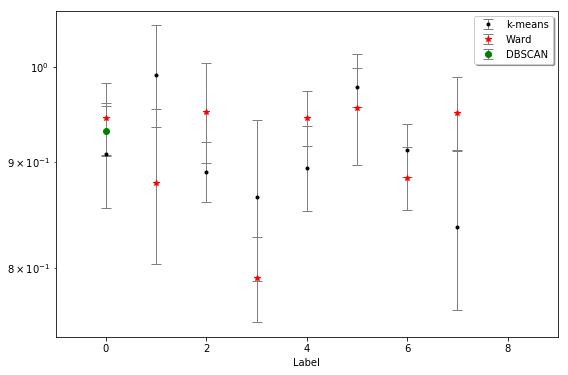

In [23]:
## Metrics of the solutions
np.random.seed(0)
labs = labels_k
qk = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_w
qw = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
#labs = labels_s
#qs = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0) 
labs = labels_d
qd = metric2(source.df, labs , APERTURE = 0.5 , MAXRADIUS = 0.9 * RADIUS, SIGCLIP = 0.0)  

plt.yscale("log", nonposy='clip')
plt.xlim([-1,kCluster+1])
plt.errorbar(qk['label'],qk['Q'], qk['Q_err'], label='k-means',fmt='.k', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qw['label'],qw['Q'], qw['Q_err'], label='Ward', fmt='*r', ecolor='gray', lw=1, capsize=5)
#plt.errorbar(qs['label'],qs['Q'], qs['Q_err'], label='Spectral', fmt='Db', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qd['label'],qd['Q'], qd['Q_err'], label='DBSCAN', fmt='og', ecolor='gray', lw=1, capsize=5)
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Label")
plt.show()

## Angular distance (1deg) : 21.0 pc


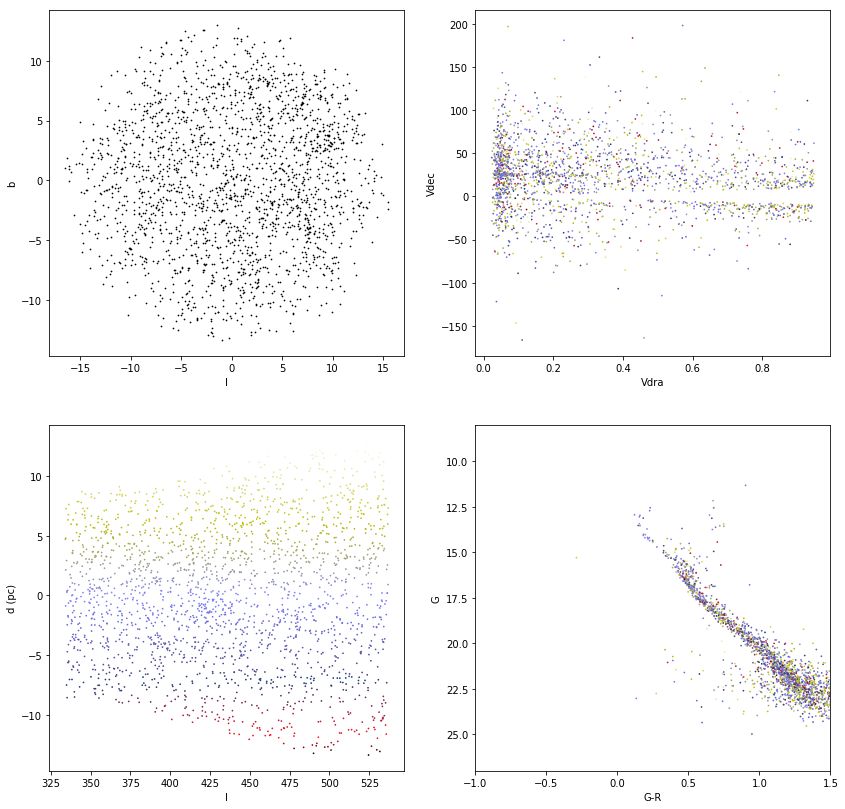

In [28]:
## separation distance
angl2pc = 3600. * 150e6 * distclust / 3.1e13
print("## Angular distance (1deg) : %3.1f pc"%(angl2pc))
plot2d(source.dfcart, labels_k,4, cmap = "gist_stern", cartesian = True)
## Density plot...
# plot_density(source.dfcart, labels_k, 3, cmap = "gist_stern", NXY = 128)
# plt.plot(source.dfcartnorm[:,0])
# plt.show()

In [25]:
## physical parameters wrt. magnitude

properties_cluster(source.dfcart, labels_d, 0)


## Physical properties of the label 0
## Pos. mean (X, Y, Z): 798.07 , 0.19 , 0.11
## Disp. (X, Y, Z): 474.89 , 15.66 , 12.97
##
## Vel. mean (RA,Dec): 0.29 , 29.67
## Vel. disp. (RA,Dec): 0.27 , 47.06
##
## Ellipticities:
## Spatial (Y/X) (Z/X) (Z/Y) : (0.03) (0.03) (0.83)
## Vel. (RA/Dec) : 0.01


[[0.03476431]
 [0.07771141]
 [0.03296427]
 ...
 [0.04712496]
 [0.05380831]
 [0.20877128]]


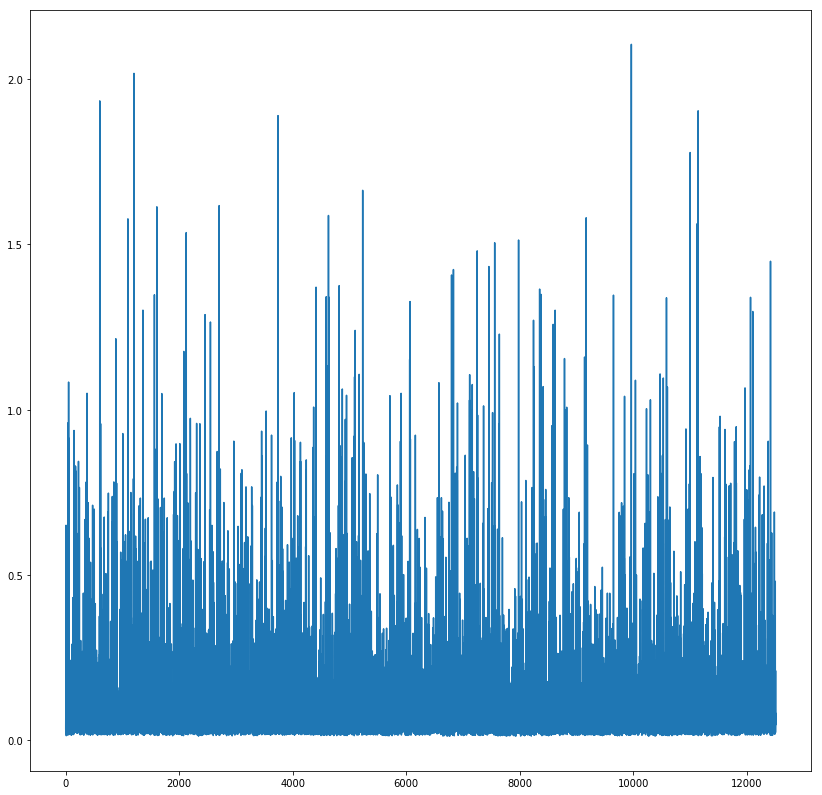

0.0124758878792954
0.12849136550983567
0.17244449624739716
Estimated number of clusters: 1


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [26]:
## parametric measurements of the clustering..

labels = labels_d
print(source.dferr)
plt.plot( source.dferr[np.where(labels == 0)])
plt.show()

print(np.min(source.dferr[np.where(labels == 0)]))
print(np.mean(source.dferr[np.where(labels == 0)]))
print(np.std(source.dferr[np.where(labels == 0)]))

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
X = source.dfcartnorm

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

